In [1]:
import tensorflow
from tensorflow import keras
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import array_to_img

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
x_train = x_train.astype('float32').reshape(60000,28*28) / 255.0
x_test = x_test.astype('float32').reshape(10000,28*28) / 255.0
y_train = y_train.reshape(60000,)
y_test = y_test.reshape(10000,)

In [4]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train).reshape(60000,10)
y_test = to_categorical(y_test).reshape(10000,10)

In [13]:
import keras_tuner as kt
import random
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.optimizers import Adam, SGD, RMSprop, Adadelta
from keras import regularizers

def optimizer(model,optimal,activate,lr):
    model.add(Dense(128,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
    model.add(Dense(10,activation='softmax',kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))

    model.compile(optimizer=globals()[optimal](learning_rate=lr),loss="categorical_crossentropy",metrics=['accuracy'])

    return model

def model_builder(hp):
    model = Sequential()
    model.add(keras.layers.Flatten(input_shape=(28*28,)))
    
    for i in range(hp.Int('num_layer',min_value=1,max_value=10)):
        model.add(Dense(hp.Int('units'+str(i), min_value=128, max_value=512,step=128),activation='relu')) # Choose units between 32-512
    activate = hp.Choice("activation",values=['relu','tanh','sigmoid']) # Choose an activation function
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) # Choose a learning from 0.01, 0.001, or 0.0001
    optimize = hp.Choice('optimizer',values=['Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD']) # Choose an optimizer
    return optimizer(model,optimize,activate,hp_learning_rate)

In [14]:
tuner = kt.Hyperband(model_builder,objective='val_accuracy',max_epochs=5,factor=3)
stop_early = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)
tuner.search(x_train,y_train,epochs=5,validation_data=(x_test,y_test), validation_split=0.2,callbacks=[stop_early])

Reloading Tuner from .\untitled_project\tuner0.json


In [15]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""Optimal learning rate is {best_hps.get('learning_rate')}.""")

Optimal learning rate is 0.001.


In [17]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test,y_test), validation_split=0.2)
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
#alternately, best val_acc_per_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print("Best epoch:%d"%(best_epoch,))

Epoch 1/50
1875/1875 [==============================] - 12s 6ms/step - loss: 1.8234 - accuracy: 0.8783 - val_loss: 0.7778 - val_accuracy: 0.9027
Epoch 2/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.7217 - accuracy: 0.9133 - val_loss: 0.6855 - val_accuracy: 0.9165
Epoch 3/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.6556 - accuracy: 0.9212 - val_loss: 0.6203 - val_accuracy: 0.9244
Epoch 4/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.6117 - accuracy: 0.9267 - val_loss: 0.6027 - val_accuracy: 0.9219
Epoch 5/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.5786 - accuracy: 0.9298 - val_loss: 0.5655 - val_accuracy: 0.9289
Epoch 6/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.5545 - accuracy: 0.9319 - val_loss: 0.5378 - val_accuracy: 0.9316
Epoch 7/50
1875/1875 [==============================] - 10s 6ms/step - loss: 0.5384 - accuracy: 0.9348 - val_loss: 0.5291 - val_ac

<Figure size 1000x500 with 0 Axes>

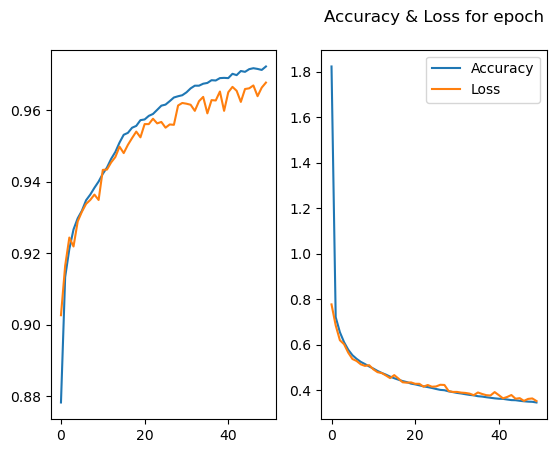

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
fig,(ax1,ax2) = plt.subplots(1,2)

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
plt.title('Accuracy & Loss for epoch',pad=20,loc='center')

plt.legend(['Accuracy','Loss'], loc='upper right')
plt.show()